In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
gs = gridspec.GridSpec(2, 2)

import matplotlib.animation
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd
import csv, json

import pims
import trackpy as tp
tp.quiet()
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, minimize
from scipy.optimize import linear_sum_assignment

from tqdm import tqdm
import joblib

from scipy.spatial import distance_matrix
from scipy.ndimage import uniform_filter1d

import random

run_analysis_verb = False
show_verb = True
save_verb = True

# TRACKPY TRACKING 
Since in movie.mp4 at frame merge_frame = 32269 two droplets merge together, the tracking procedure is divided into two parts: \
    - Pre merge [0:merge_frame] --> 50 features to locate \
    - Post merge [merge_frame:] --> 49 features to locate

In [2]:
# PRE PROCESSING
@pims.pipeline
def trackpy_preprocessing(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

In [5]:
# import video with pre processing applied
data = trackpy_preprocessing(pims.open('./data/49b1r.mp4'), 55, 55, 880, 880)
data_ref = pims.open('./data/49b1r.mp4')

deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


In [12]:
from scipy import ndimage

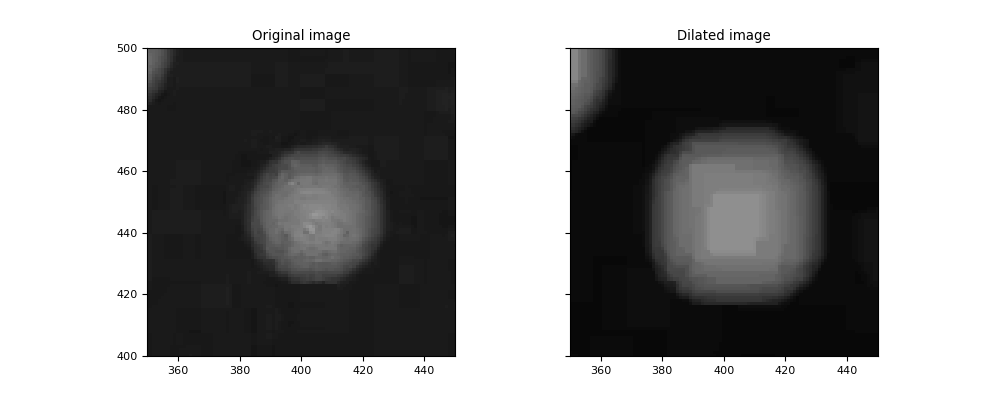

In [54]:
image = data[0]#cv2.bitwise_not(data[0]) 
ndim = image.ndim
separation = (10, 10)

not_black = image[np.nonzero(image)]
threshold = np.percentile(not_black, 64)

# Find the largest box that fits inside the ellipse given by separation
size = [int(2 * s / np.sqrt(ndim)) for s in separation]

# The intersection of the image with its dilation gives local maxima.
dilation = ndimage.grey_dilation(image, size, mode='constant')

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4),sharex=True, sharey=True)
ax.imshow(image)
ax.set_title('Original image')
ax1.imshow(dilation)
ax1.set_title('Dilated image')
ax.set(xlim=(350, 450), ylim = (400, 500))
plt.show()

In [ ]:
frame = 0
fig, (ax, ax1) = plt.subplots(1, 2)
ax.imshow(data_ref[frame])
ax.set(title = f'Original - frame {frame}', xlabel = 'X [px]', ylabel = 'Y [px]')
ax1.imshow(data[frame])
ax1.set(title = f'Processed - frame {frame}', xlabel = 'X [px]', ylabel = 'Y [px]')
plt.tight_layout()
if save_verb: plt.savefig('./results/pre_processing_example.png', bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## PRE MERGE 

In [ ]:
run_analysis_verb = False
if run_analysis_verb:
    ###############################################################################################
    #                                           PARAMETERS                                        #
    ###############################################################################################
    dropSize = 31  
    minMass = 2000
    sep = 16
    nDrops = 50
    trackpy_params = {"dropSize": dropSize, "minMass": minMass, "sep": sep, "nDrops": nDrops}
    # save parameters used for the trial tracking:
    with open('./results/tracking_data/trackpy_trial_params.txt', 'w') as fp:
        json.dump(trackpy_params, fp)

    ###############################################################################################
    #                                     FEATURES LOCATION                                       #
    ###############################################################################################
    nFrames = 100 # up to merge_frame
    startFrame = 0
    endFrame = startFrame + nFrames
    f = tp.batch(data[startFrame:endFrame], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
    display(f)

    ###############################################################################################
    #                                      FEATURES LINKING                                       #
    ###############################################################################################
    t = tp.link_df(f, 150, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    display(t)

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t.particle)
    print(n)
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    trajectory = t.copy()
    trajectory.to_parquet('./results/tracking_data/trackpy_trial.parquet')
    display(trajectory)
else:
    try:
        trajectory = pd.read_parquet('./results/tracking_data/trackpy_pre_merge_sorted_and_colored.parquet')
        display(trajectory)
    except:
        print("ERROR: no trajectory data found")

In [ ]:
"""
# need to work on this

# ANOMALIES DETECTION
num = np.zeros(1000)
for i in range(1000):
    num[i] = len(f.loc[f['frame'] == i + startFrame])

idx = np.where(num != nDrops)[0]
print(idx)
if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

t = tp.link_df(f, 50, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
t = tp.filter_stubs(t, 50)

# ANOMALIES DETECTION
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c

display(t)
df = t.loc[(t.frame == startFrame+100) , ["x", "y", "color"]]
fig, ax = plt.subplots(1, 1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 50)
ax.imshow(data_preload[100])
plt.show()
df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]

fig, (ax, ax1) = plt.subplots(1, 2)
ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
ax.imshow(data[f1])
df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
ax1.imshow(data[f2])
plt.show()
lost_particles = []
for i in range(nFrames-1):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])
print("Total problems:", len(lost_particles))
print(ind)

if len(lost_particles) > 0: 
    print(f"First failure occurred at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(data[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(data[f2])

    plt.show()
"""

In [ ]:
red_particle_id = 17 # may vary !!
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(trajectory.loc[trajectory.particle == 0].x, trajectory.loc[trajectory.particle == 0].y, color = 'b')
ax.plot(trajectory.loc[trajectory.particle == red_particle_id].x, trajectory.loc[trajectory.particle == red_particle_id].y, color = 'r')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Example of particle trajectory')
ax.legend(['Blue droplet', 'Red droplet'])
ax.grid()
plt.savefig('./results/trajectory_example.png', bbox_inches = 'tight')
plt.show()

In [ ]:
# animated plot of the tracking results
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x","y","color","size"]]
    for i in range(50):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = 2*df["size"].values[i]
    graph2.set_data(data[frame])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking raw - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == 0), ["x","y","color","size"]]

graph = []
for i in range(50):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), 2*df["size"].values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, max(trajectory.frame), 1), interval = 5, blit=False)
if 0: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save('./results/tracking_raw_trial.mp4', writer=writer, dpi = 300)
plt.show()

## POST MERGE  - to do

In [ ]:
# parameters of the tracking
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 49
merge_frame = 32269
# FEATURES LOCATION
nFrames = 100 # total number of frames of video --> len(data)
startFrame = merge_frame + 100 
endFrame = len(data) #startFrame + nFrames

preload = True # takes 20 minutes
if preload:
    data_preload = list(data[startFrame:endFrame])

In [ ]:
# 431 mins for the full post merge video
f = tp.batch(data_preload, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
f.frame = f.frame + startFrame
display(f)
f.to_parquet('./results/tracking_data/tracking_raw_trial.parquet.gzip', compression = 'gzip')

In [ ]:
temp = f.groupby("frame").count()
err_frames = temp.loc[temp.x != 49].index.values
print(err_frames)
for i in err_frames:
    print(len(f.loc[f.frame == i]))
fig, ax = plt.subplots(1, 1)
ax.imshow(data_preload[err_frames[1]-startFrame])
ax.scatter(f.loc[f.frame == err_frames[1]].x, f.loc[f.frame == err_frames[1]].y, s=50, ec = "w")
plt.show()

In [ ]:
f_no_err = f.loc[f.frame < err_frames[0]]
if 1: t = tp.link_df(f_no_err, 200, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
temp = t.groupby("frame").mean()
err_frames2 = temp.loc[temp.particle != 24].index.values
print(err_frames2)

In [ ]:
fig, ax= plt.subplots(1, 1)
ax.imshow(data_preload[err_frames2[0]-startFrame])
ax.scatter(f.loc[f.frame == err_frames2[0]].x, f.loc[f.frame == err_frames2[0]].y, s=50, ec = "w")
plt.show()

# HOUGH TRANSFORM METHOD (CLASS TRIAL) -- IN DEVELOPMENT

In [ ]:
@pims.pipeline
def hough_preprocessing(image, x1, y1, x2, y2):    
    """
    Pims pipeline preprocessing of the image for the HoughCircles function.
    Crops the image to remove the petri dish, converts the image to grayscale and applies a median filter.

    Parameters
    ----------
    image: image
        image to preprocess.
    x1, y1, x2, y2: int
        coordinates of the circle to crop.
    Returns
    -------
    npImage: array
        image to be analyzed.
    """
    npImage = np.array(image)
    #npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2HSV)
    # Create same size alpha layer with circle
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha #npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 5)
    return npImage

	
def hough_loc_frame(correct_n, frame, img, parameters):
	"""
	Hough transform to locate the droplets in the frame.

	Parameters
	----------
	correct_n: int
		number of droplets in the frame.
	frame: int
		frame to be analyzed.
	img: image
		image for the HoughCircles function.
	parameters: dict
		parameters for the HoughCircles function.
	
	Returns
	-------
	if found_circles is not None and the number of droplets found is equal to correct_n:
		x, y position of the droplets, diameter of the droplets, frame, correct_n.
	if found_circles is not None and the number of droplets found is not equal to correct_n:
		x, y position (0,0), diameter of the droplets (0), frame, number of droplets found.
	else:
		x, y position (0,0), diameter of the droplets (0), frame, 0.
	"""
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
						  np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	"""
	if (found_circles is not None) and (found_circles.shape[1] == correct_n):
		return np.hstack((found_circles[0], (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*correct_n))
	elif (found_circles is not None) and (found_circles.shape[1] != correct_n):
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.zeros((correct_n, 1), dtype=int)))
	"""

def hough_feature_location(data_preload, fr, startFrame, correct_n, params, progress_verb):
	"""
	Locates the droplets in the frames using the HoughCircles function.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	data_preload: list
		list of images to be analyzed.
	frames: array
		frames to be analyzed.
	correct_n: int
		number of droplets in the frame.
	params: dict
		parameters for the HoughCircles function.
	progress_verb: bool
		if True, shows the progress bar.

	Returns
	-------
	temp: dataframe
		dataframe with the x, y, d, frame, nDroplets of the found circles in the frames.
	err_frames: array
		frames where the number of droplets found is different from the correct_n.
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	if progress_verb:
		temp = []
		for i in tqdm(fr):
			temp.append(hough_loc_frame(correct_n, i, data_preload[i-startFrame], params))
	else:
		temp = []
		for i in fr:
			temp.append(hough_loc_frame(correct_n, i , data_preload[i-startFrame], params))

	temp_df = pd.DataFrame(np.concatenate([arr for arr in temp]), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp_df["frame"] = temp_df["frame"].astype(int)
	temp_df["nDroplets"] = temp_df["nDroplets"].astype(int)
	err_frames = temp_df.loc[temp_df.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/frames.shape[0]
	return temp_df, err_frames, loss

def optimize_params(x, *args):
	"""
	Optimizes the parameters for the HoughCircles function and saves the set of parameters with the best score.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	x: array
		parameters for the HoughCircles function.
	args: tuple
		data_preload, frames, startFrame, correct_n, traj_part.
	
	Returns
	-------
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	data, frames, startFrame, correct_n, traj_part = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for i in frames:#tqdm(frames):
		found_circles = cv2.HoughCircles(data_preload[i-startFrame], cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
	loss = errs/frames.shape[0]
	
	# Save the current best score and set of parameters to a CSV file
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	
	with open(f"./results/tracking_data/hough/{traj_part}_opt.csv", mode = 'a', newline='') as file:
	   writer = csv.writer(file)
	   writer.writerow(a)
	print(a)
	return loss
	

def plot_opt_results(opt_result_df):
	"""
	Plots the loss and the parameter slot2.
	
	Parameters
	----------
	opt_result_df: dataframe
		dataframe with the loss and the parameters.
	slot2: str
		parameter to be plotted.
	
	Returns
	-------
	fig: figure
		figure with the loss and the parameter slot2.
	"""
	fig, ax = plt.subplots(1, 1, figsize = (10, 4))
	for slot in opt_result_df.columns:
		ax.plot(np.arange(0, len(opt_result_df)), np.interp(opt_result_df[slot], [opt_result_df[slot].min(), opt_result_df[slot].max()], [0, 1]), label = slot)
	# Shrink current axis by 20%
	box = ax.get_position()
	ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

	# Put a legend to the right of the current axis
	ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
	return fig

In [ ]:
# SETUP
preload_load_data = False # takes 20 min
merge_frame = 32269 
traj_part = "pre_merge" # choose which trajectory part to run --> "pre_merge" or "post_merge"
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
print(data)

if traj_part == "pre_merge":
    startFrame = 0
    endFrame = merge_frame
    frames = np.arange(startFrame, endFrame, 1)
    correct_n = 50
    if preload_load_data:
        data_preload_pre_merge = list(data[startFrame:endFrame])
elif traj_part == "post_merge":
    startFrame = merge_frame + 1
    endFrame = len(data)
    frames = np.arange(startFrame, endFrame, 1)
    correct_n = 49
    if preload_load_data: 
        data_preload_post_merge = list(data[startFrame:endFrame])
else:
    raise ValueError("traj_part must be either 'pre_merge' or 'post_merge'")
default_parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}

In [ ]:
class TrajectoryProcessing:
    def __init__(self, data_preload, traj_part, frames, correct_n):
        self.traj_part = traj_part
        self.correct_n = correct_n
        self.frames = frames
        self.startFrame = frames[0]
        self.parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}
            
    def parameters_optimization(self, data_preload, nSample, maxfunEvals, run_verb = False, plot_verb=False):
        if run_verb:
            if not os.path.exists(f"./results/tracking_data/hough/{self.traj_part}_opt.csv"):
                # initialize the CSV file with the header if it does not exist
                with open(f"./results/tracking_data/hough/{self.traj_part}_opt.csv", mode='w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['loss', 'dp', 'minDist', 'param1', 'param2', 'minRadius', 'maxRadius'])

            # randomly select nSample frames to optimize --> change this number if needed
            opt_sample = np.sort(random.sample(list(self.frames), nSample)) 
            print(f"Starting optimization on {len(opt_sample)} frames...")
            # paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
            init_guess =  [2, 8, 20, 0.8, 10, 35] # initial guess for the parameters
            params_bounds = [(1, 3), (5, 20), (20, 200), (0.3, 1), (5, 20), (20, 40)] # bounds for the parameters
            
            opt_result = dual_annealing(optimize_params, x0 = init_guess, \
                                        args = (data_preload, opt_sample, startFrame, self.correct_n, self.traj_part),\
                                        bounds = params_bounds, maxfun=maxfunEvals)
            print(opt_result)
            if plot_verb: plot_opt_results(opt_result, self.traj_part)
            self.parameters = {"dp": opt_result.x[0], "minDist": opt_result.x[1], "param1": opt_result.x[2],\
                                        "param2": opt_result.x[3], "minRadius": opt_result.x[4], "maxRadius": opt_result.x[5]}
        else:
            try:
                opt_result_df = pd.read_csv(f"./results/tracking_data/hough/{traj_part}_opt.csv").sort_values("loss", ascending=False)
            except:
                raise Exception("No optimization results found")
            # the best set of parameters is the one that minimizes the loss
            optimized_parameters = {"dp": opt_result_df.iloc[-1].dp, "minDist": opt_result_df.iloc[-1].minDist,\
                                    "param1": opt_result_df.iloc[-1].param1, "param2": opt_result_df.iloc[-1].param2,\
                                    "minRadius": int(opt_result_df.iloc[-1].minRadius), "maxRadius": int(opt_result_df.iloc[-1].maxRadius)}
            self.parameters = optimized_parameters
            display(opt_result_df.tail(20))
            #print("Optimized parameters:", self.parameters)
            if plot_verb: plot_opt_results(opt_result_df)
        

    def run_location_and_linking(self, data_preload, run_verb):
        if run_verb:
            # save to txt parameters:
            with open(f'./results/tracking_data/hough/hough_{traj_part}.txt', 'w') as f:
                f.write(json.dumps(self.parameters))

            print("Running hough feature location...")
            self.hough_df, self.err_frames, self.error = hough_feature_location(data_preload, self.frames, self.correct_n, self.parameters, True)
            self.hough_df.to_parquet(f"./results/tracking_data/hough/hough_{traj_part}.parquet")

            print("Running trackpy linking...")
            self.linked_df = tp.link(self.hough_df, search_range = 150, memory = 2, link_strategy = 'hybrid',\
                                        neighbor_strategy = 'KDTree', adaptive_stop = 1)
            self.linked_df = self.linked_df.sort_values(by=['frame', 'particle'])
            with open('./results/tracking_data/colors.txt', 'r') as filehandle:
                colors = json.load(filehandle)
            c = []
            for p in self.linked_df.particle:
                c.append(colors[p])
            self.linked_df["color"] = c
            self.linked_df.to_parquet(f"./results/tracking_data/hough/linked_{traj_part}.parquet")
        else:
            try:
                self.parameters = json.load(open(f'./results/tracking_data/hough/hough_{traj_part}.txt'))
                self.linked_df = pd.read_parquet(f"./results/tracking_data/hough/linked_{traj_part}.parquet")
            except:
                raise Exception(f"No {traj_part} data found, run analysis first")

In [ ]:
test = TrajectoryProcessing(data_preload, traj_part, frames, correct_n)
test.parameters_optimization(data_preload, 50, 100, run_verb = False, plot_verb=True)
#test.run_location_and_linking(data_preload, True)

In [ ]:
def analyze_result(benchmark_traj, df, startFrame, endFrame, benchmark_particle_id):
    confront_traj = df.loc[(df.frame.between(startFrame, endFrame)) & (df.particle == benchmark_particle_id)]
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.plot(benchmark_traj.x, benchmark_traj.y, label = "benchmark")
    ax.plot(confront_traj.x, confront_traj.y, label = "confront")
    ax.legend()
    plt.show()
benchmark_traj = pd.read_csv(f"./results/error_estimation/benchmark_traj.csv")
startFrame = 18300
endFrame = 18900 
analyze_result(benchmark_traj, test.linked_df, startFrame, endFrame, 9)
aaaa = test.linked_df.loc[test.linked_df.particle == 0]
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(aaaa.x, aaaa.y)
plt.show()

# HOUGH TRACKING

In [2]:
@joblib.delayed
def loc_frame(correct_n, frame, img, parameters):
	temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	if (temp is not None) and (temp.shape[1] == correct_n):
		return np.hstack((temp[0], (np.ones((correct_n, 1), dtype=int)*frame), np.ones((correct_n, 1), dtype=int)*correct_n))
	elif (temp is not None) and (temp.shape[1] != correct_n):
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame), np.ones((correct_n, 1), dtype=int)*temp.shape[1]))
	else:
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame), np.zeros((correct_n, 1), dtype=int)))


def hough_feature_location(data_preload, frames, correct_n, params, progress):
    parallel = joblib.Parallel(n_jobs = -2)
    if progress:
        temp = parallel(
            loc_frame(correct_n, frame, data_preload[frame-frames[0]], params)
            for frame in tqdm(frames)
        )
    else:
        temp = parallel(
            loc_frame(correct_n, frame, data_preload[frame-frames[0]], params)
            for frame in frames
        )
    temp = pd.DataFrame(np.array(temp).reshape(len(frames)*correct_n, 5), columns = ["x", "y", "d", "frame", "nDroplets"])
    err_frames = temp.loc[temp.nDroplets != correct_n].frame.unique().astype(int)
    loss = err_frames.shape[0]/frames.shape[0]
    return temp, err_frames, loss

def optimize_params(x, *args):
    data_preload, frames, correct_n, writer = args
    params = {"dp":x[0], "minDist":x[1], "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
    _, _, loss = hough_feature_location(data_preload, frames, correct_n, params, False)
    # write to csv loss and parameters
    writer.writerow([loss] + list(params.values()))
    return loss

def plot_optimization_results(opt_result_df, slot2):
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.arange(0, len(opt_result_df.loss), 1), opt_result_df.loss, 'b-')
    ax.set_ylabel("loss", color = 'b') 
    ax1 = ax.twinx() 
    ax1.plot(np.arange(0, len(opt_result_df[slot2]), 1), opt_result_df[slot2], 'r.')
    ax1.set_ylabel(slot2, color='r')
    ax.grid()
    plt.show()
    return fig

## PRE MERGE

In [24]:
@pims.pipeline
def hough_preprocessing(image, x1, y1, x2, y2):    
    #image = cv2.GaussianBlur(image, ksize = [7,7], sigmaX = 1.5, sigmaY = 1.5)
    npImage = np.array(image)
    # Create same size alpha layer with circle
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha #npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 7)
    return npImage

deprecated pixel format used, make sure you did set range correctly


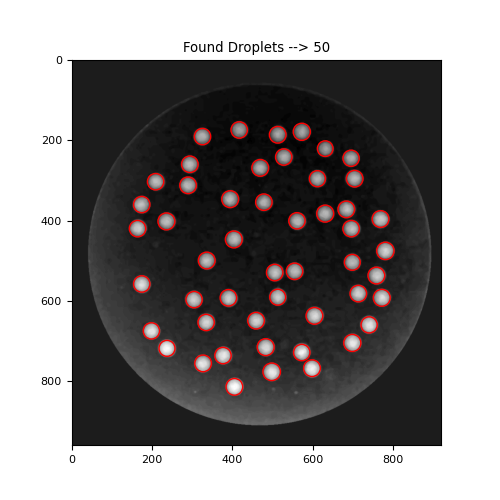

In [25]:
default_parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
circ = cv2.HoughCircles(data[0], cv2.HOUGH_GRADIENT_ALT, **default_parameters)[0]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.imshow(data[0])
for i in range(circ.shape[0]):
    ax.add_artist(plt.Circle((circ[i, 0], circ[i, 1]), circ[i, 2], color='r', fill=False))
ax.set_title(f"Found Droplets --> {circ.shape[0]}")
plt.show()

In [26]:
# SETUP
preload_load_data = True # takes 20 min
merge_frame = 32269
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
if preload_load_data: 
    data_preload = list(data[:merge_frame])
else:
    data_preload = None

startFrame = 0
endFrame = merge_frame
frames = np.arange(startFrame, endFrame, 1)
frames_opt = np.sort(random.sample(list(frames), 1000))
correct_n = 50
default_parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}

deprecated pixel format used, make sure you did set range correctly


In [ ]:
optimization_verb = True
run_optimization_verb = False
if optimization_verb:
    if run_optimization_verb:
        with open("./results/tracking_data/hough/pre_merge_optimization.csv", 'w') as f1:
            writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
            writer.writerow(["loss", "dp", "minDist", "param1", "param2", "minRadius", "maxRadius"])
            opt_result = dual_annealing(optimize_params, x0 = [1.5, 15, 200, 0.9, 15, 25], \
                                        args = (data_preload, frames_opt, correct_n, writer),\
                                        bounds = [(1, 3), (5, 20), (80, 200), (0.3, 1), (5, 20), (20, 30)],\
                                        maxiter = 2000)
    else:
        try:
            opt_result_df = pd.read_csv("./results/tracking_data/hough/pre_merge_optimization.csv", sep="\t").sort_values("loss", ascending=False)
            opt_result_df = opt_result_df.sort_values("loss", ascending=False)
            optimized_parameters = opt_result_df.iloc[-1]
            optimized_parameters = {"dp": optimized_parameters.dp, "minDist": optimized_parameters.minDist,\
                                    "param1": optimized_parameters.param1, "param2": optimized_parameters.param2,\
                                    "minRadius": int(optimized_parameters.minRadius), "maxRadius": int(optimized_parameters.maxRadius)}
            parameters = optimized_parameters
            print("Optimized parameters:", parameters)
            fig, ax = plt.subplots(1, 1, figsize = (10, 3))
            ax.plot(opt_result_df.loss.values)
            ax.set_ylabel("loss")
            ax.set_xlabel("iteration")
            ax.grid()
            plt.show()
        except:
            raise Exception("No optimization results found")
else:
    parameters = default_parameters
    print("Default parameters:", parameters)

In [ ]:
#opt_result_df = opt_result_df
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(opt_result_df.loss.values)
ax.set_ylabel("loss")
ax.set_xlabel("iteration")
ax.grid()
plt.show()

for i in range(len(parameters)):
    param = list(parameters.keys())[i]
    fig, ax = plt.subplots(1, 1, figsize = (10, 3))
    ax.scatter(opt_result_df[param], opt_result_df.loss.values, c = 'b', marker = 'o')
    ax.set_ylabel("loss")
    ax.set_xlabel(param)
    ax.grid()
    plt.show()

In [ ]:
if 1:
    # save to txt parameters:
    with open('./results/tracking_data/hough/hough_pre_merge.txt', 'w') as f:
        f.write(json.dumps(parameters))
    pre_merge_df, err_frames, error = hough_feature_location(data_preload, frames, correct_n, parameters, False)
    pre_merge_df.to_parquet("./results/tracking_data/hough_pre_merge.parquet")
else:
    try:
        parameters = json.load(open('./results/tracking_data/hough/hough_pre_merge.txt'))
        pre_merge_df = pd.read_parquet("./results/tracking_data/hough/hough_pre_merge.parquet")
        print(parameters)
        display(pre_merge_df)
    except:
        raise Exception("No pre merge data found, run analysis first")

In [ ]:
frames = (pre_merge_df.frame.values[::correct_n]).astype(int)
print(f"Number of frames: {len(frames)}")
err_frames = pre_merge_df.loc[pre_merge_df.nDroplets != correct_n].frame.unique().astype(int)
print(f"Percentage of error: {len(err_frames)}/{len(frames)}")

In [ ]:
err_frames

## POST MERGE 

In [ ]:
# SETUP
preload_load_data = False # takes 20 min
merge_frame = 32269
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
if preload_load_data: data_preload = list(data[merge_frame:])

startFrame = merge_frame
endFrame = len(data) 
frames = np.arange(startFrame, endFrame, 1)
opt_test_frames = np.arange(startFrame, endFrame, 500)
correct_n = 49
default_parameters = {"dp": 1.5, "minDist": 10, "param1": 100, "param2": 0.8, "minRadius": 10, "maxRadius": 30}

In [ ]:
optimization_verb = True
run_optimization_verb = False
if optimization_verb:
    if run_optimization_verb:
        with open("./results/tracking_data/hough/post_merge_optimization.csv", 'w') as f1:
            writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
            writer.writerow(["loss", "dp", "minDist", "param1", "param2", "minRadius", "maxRadius"])
            opt_result = dual_annealing(optimize_params, x0 = [1.5, 15, 100, 0.9, 15, 25], \
                                        args = (data_preload, opt_test_frames, correct_n, writer),\
                                        bounds = [(1, 3), (5, 20), (50, 200), (0.3, 1), (5, 20), (10, 30)],\
                                        maxiter = 2000)
    else:
        opt_result_df = pd.read_csv("./results/tracking_data/hough/post_merge_optimization.csv", sep="\t").sort_values("loss", ascending=False)
        # plot example of optimization result, in this case minRadius, can be any parameter
        plot_optimization_results(opt_result_df, "minRadius")
        
        optimized_parameters = opt_result_df.iloc[-1]
        optimized_parameters = {"dp": optimized_parameters.dp, "minDist": optimized_parameters.minDist,\
                                "param1": optimized_parameters.param1, "param2": optimized_parameters.param2,\
                                "minRadius": int(optimized_parameters.minRadius), "maxRadius": int(optimized_parameters.maxRadius)}
        parameters = optimized_parameters
        print("Optimized parameters:", parameters)
else:
    parameters = default_parameters
    print("default parameters:", parameters)

In [ ]:
if run_analysis_verb:
    # save to txt parameters:
    with open('./results/tracking_data/hough/hough_post_merge.txt', 'w') as f:
        f.write(json.dumps(parameters))
    post_merge_df, err_frames, error = hough_feature_location(data_preload, frames, correct_n, parameters)
    post_merge_df.to_parquet("./results/tracking_data/hough/hough_post_merge.parquet")
else:
    try:
        parameters = json.load(open('./results/tracking_data/hough/hough_post_merge.txt'))
        post_merge_df = pd.read_parquet("./results/tracking_data/hough/hough_post_merge.parquet")
        print(parameters)
        display(post_merge_df)
    except:
        raise Exception("No post merge data found, run analysis first")

In [ ]:
frames = (post_merge_df.frame.values[::correct_n]).astype(int)
print(f"Number of frames: {len(frames)}")
err_frames = frames[0] + np.where(post_merge_df.groupby("frame").mean().x==0)[0]
print(f"Percentage of error: {len(err_frames)}/{len(frames)}")

In [ ]:
# example of a frame with errors
problem_frame = frames[np.where(post_merge_df.groupby("frame").mean().nDroplets == 48)[0][-1]] #- merge_frame
example = cv2.HoughCircles(data_preload[problem_frame], cv2.HOUGH_GRADIENT_ALT, **parameters)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(gs[0, 1]) 
ax1.plot(frames, test_result.groupby("frame").mean().nDroplets, 'b-')
ax1.set(title = "Detected droplets", ylabel = "n")
ax1.grid()

ax2 = fig.add_subplot(gs[1, 1]) 
ax2.plot(frames, test_result.d.values.reshape(len(frames), correct_n), 'b.', markersize=1)
ax2.set(xlabel = "Frame", ylabel = "d [px]", title = "Droplets diameter")
ax2.grid()

ax3 = fig.add_subplot(gs[:, 0]) 
ax3.imshow(data_preload[problem_frame], cmap = "gray")
ax3.set(title=f"Detected droplets: {example.shape[1]} - Frame: {problem_frame + merge_frame}", xlabel = "X [px]", ylabel = "Y [px]")
for i in range(example.shape[1]):
    ax3.add_patch(plt.Circle((example[0][i][0], example[0][i][1]), example[0][i][2], color = "r", fill = False))
plt.tight_layout()
plt.show()

# LINK HOUGH RESULT TO TRACKPY RESULT

In [ ]:
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
nFrames = len(data)
merge_frame = 32269

In [ ]:
trackpy_df = pd.read_parquet("./results/tracking_data/trackpy_pre_merge_sorted_and_colored.parquet")
colors = trackpy_df.loc[trackpy_df.frame == 0].color.values

hough_df = pd.read_parquet("./results/tracking_data/hough/hough_pre_merge.parquet").replace(0, np.nan)
hough_df.loc[:49, ["frame"]] = 0
correct_n = 50
hough_df = hough_df.loc[hough_df.frame.between(0, max(trackpy_df.frame)), :]
# initialize particle id to -1
hough_df["particle"] = np.ones(len(hough_df), dtype=int)*(-1)
# add flag column to keep record of error frames in which trackpy position 
hough_df["flag"] = np.zeros(len(hough_df), dtype=int)
# error frames !!
pre_merge_err_frames = np.where(hough_df.groupby("frame").mean().x.isna())[0]

In [ ]:
# associate at each frame droplet ID from trackpy to the one from hough circles by minimizing distance matrix
link_verb = False
if link_verb:
    hough_trackpy_df = hough_df.copy()
    for frame in tqdm(range(max(trackpy_df.frame)+1)):
        # frames with error in hough circle detection --> use trackpy result
        if frame in pre_merge_err_frames:
            # change flag to 1 to denote the fact that trackpy result is used
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, "flag"] = np.ones(correct_n, dtype=int)
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["x", "y", "frame", "particle"]] = trackpy_df.loc[trackpy_df.frame == frame, ["x", "y", "frame", "particle"]]

        hoguh_frame = hough_trackpy_df.loc[hough_df.frame == frame]
        trackpy_frame = trackpy_df.loc[trackpy_df.frame == frame]
        dist = distance_matrix(hoguh_frame[["x", "y"]].values, trackpy_frame[["x", "y"]].values)
        row_ind, col_ind = linear_sum_assignment(dist)
        hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["particle"]] = trackpy_frame.loc[:, ["particle"]].values[col_ind,:]

    c = []
    for p in hough_trackpy_df.particle:
        c.append(colors[p])
    hough_trackpy_df["color"] = c
    hough_trackpy_df.sort_values(by=["frame", "particle"], inplace=True)
    hough_trackpy_df = hough_trackpy_df.reset_index().drop(columns=["index"])
    display(hough_trackpy_df)
    hough_trackpy_df.to_parquet("./results/tracking_data/tracking_hough_trackpy_linking.parquet")
else:
    try:
        hough_trackpy_df = pd.read_parquet("./results/tracking_data/tracking_hough_trackpy_linking.parquet")
    except:
        print("No parquet file found, run the linking code")

In [ ]:
err_frames = np.where(hough_trackpy_df.groupby("frame").mean().flag==1)[0]
print(f"Number of errors: {len(err_frames)}/{int(max(hough_trackpy_df.frame))}")

In [ ]:
frame = 100
hough_temp = hough_trackpy_df.loc[(hough_trackpy_df.frame == frame)] #  & (hough_df.particle == 10)
trackpy_temp = trackpy_df.loc[(trackpy_df.frame == frame) ] #  & (trackpy_df.particle == 10)

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4))
ax.imshow(data[frame])
#ax.scatter(trackpy_temp.x.values, trackpy_temp.y.values, color = trackpy_temp.color.values)
ax.set(title = "Trackpy result")
ax1.imshow(data[frame])
#ax1.scatter(hough_temp.x.values, hough_temp.y.values, color = hough_temp.color.values)
ax1.set(title = "Hough result")

for i in range(50):
    ax.add_artist(plt.Circle((trackpy_temp.x.values[i],\
                               trackpy_temp.y.values[i]), \
                               2*trackpy_temp["size"].values[i],\
                               color = trackpy_temp.color.values[i], fill=False, linewidth=1))
    
    ax1.add_artist(plt.Circle((hough_temp.x.values[i], \
                              hough_temp.y.values[i]),\
                              hough_temp.d.values[i],\
                              color = hough_temp.color.values[i], fill=False, linewidth=1))

plt.show()

In [ ]:
red_particle_id = 17 # may vary !!
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(hough_trackpy_df.loc[hough_trackpy_df.particle == 0].x, hough_trackpy_df.loc[hough_trackpy_df.particle == 0].y, color = 'b')
ax.plot(hough_trackpy_df.loc[hough_trackpy_df.particle == red_particle_id].x,\
         hough_trackpy_df.loc[hough_trackpy_df.particle == red_particle_id].y, color = 'r')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Example of particle trajectory')
ax.legend(['Blue droplet', 'Red droplet'])
ax.grid()
plt.savefig('./results/trajectory_example_hough.png', bbox_inches = 'tight')
plt.show()

In [ ]:
fig = plt.figure(figsize = (5, 5))
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=None, hspace=None)
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = hough_df.loc[(hough_df.frame == frame) , ["x","y","color","d"]]
    for i in range(50):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.d.values[i]
    graph2.set_data(data[frame])
    title.set_text('Hough features location & Trackpy linking - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Hough features location & Trackpy linking - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = hough_df.loc[(hough_df.frame == 0), ["x","y","color","d"]]

graph = []
for i in range(50):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.d.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, int(max(hough_df.frame)), 1), interval = 5, blit=False)
if 0: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save('./results/tracking_hough_trackpy_linking.mp4', writer=writer, dpi = 300)
plt.show()

# DIMENSION OF DROPLETS ANALYSIS

## TRACKPY
note that at http://soft-matter.github.io/trackpy/v0.6.1/generated/trackpy.locate.html#trackpy.locate "size" is said to be the radius of gyration of its Gaussian-like profile

In [ ]:
rawTrajs = pd.read_parquet("./results/tracking_data/trackpy_full.parquet")
mean_dim = rawTrajs.groupby("frame").mean()
merge_frame = 32269

fig, ax = plt.subplots(1, 1)
ax.plot(mean_dim.index/10, 2*mean_dim["size"])
ax.vlines(merge_frame/10, 2*mean_dim["size"].values.min(), 2*mean_dim["size"].max(), color="r")
ax.set(xlabel = "Time [s]", ylabel = "d [px]", title = "Mean particle diameter")
ax.grid(True, linestyle='-', color = '0.75')
if save_verb: plt.savefig("./results/dimension_analysis/mean_diameter_trackpy.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
# windowed ?
nFrames = len(mean_dim)
print(nFrames)
# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

# mean and std droplet diameter per frame
mean_d_wind = np.zeros(nSteps)
std_d_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    mean_d_wind[i] = np.mean(2*mean_dim["size"][start:start+window])
    std_d_wind[i] = np.std(2*mean_dim["size"][start:start+window])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(startFrames/10, mean_d_wind)
ax.vlines(merge_frame/10, mean_d_wind.min(), mean_d_wind.max(), color="r")
ax.fill_between(startFrames/10, mean_d_wind - std_d_wind, mean_d_wind + std_d_wind, alpha=0.5)
ax.set(xlabel = "Window Time [s]", ylabel = "d [px]", title = "Droplet diameter over window time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

## confront trackpy and hough circle results

In [ ]:
hough_df2 = pd.read_parquet("./results/tracking_data/tracking_hough_trackpy_linking.parquet")

In [ ]:
hough_mean_d = hough_df2.groupby("frame").mean().d
merge_frame = 32269
fig, ax = plt.subplots(1, 1)
ax.plot(hough_mean_d.index/10, hough_mean_d)
ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "Mean particle radius")
ax.grid(True, linestyle='-', color = '0.75')
plt.savefig("./results/dimension_analysis/mean_diameter_hough_trackpy.png", bbox_inches='tight')
plt.show()

In [ ]:
rawTrajs = pd.read_parquet("./results/tracking_data/trackpy_pre_merge_sorted_and_colored.parquet")
trackpy_mean_d = rawTrajs.groupby("frame").mean()["size"]
merge_frame = 32269

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(hough_mean_d.index/10, hough_mean_d)
ax.plot(trackpy_mean_d.index/10, 2*trackpy_mean_d)
ax.set(xlabel = "Time [s]", ylabel = "d [px]", title = "Mean particle diameter")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

# TRACKING ERROR ESTIMATION

I note that between frames 18300 and 18900 a droplet 40 seems stable and isolated.\
Then applying a rectangular mask around it I compute the "benchmark" position of the droplet using Canny Edge Detection and Hough Transform.\
Finally I confront the tracking result with the benchmark and different window sizes of smoothing.

In [ ]:
# apply mask to perform edge detection only on the benchmark particle
@pims.pipeline
def crop(image, x1, y1, x2, y2):   
    npImage = np.array(image)
    alpha = Image.new('L', (920, 960), 0)
    draw = ImageDraw.Draw(alpha)
    draw.rectangle([(x1, y1), (x2, y2)], fill = 255)
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    return npImage

In [ ]:
startFrame = 18300
endFrame = 18900
framesArray = np.arange(startFrame, endFrame, 1) 

traj_verb = "hough"

if traj_verb == "trackpy": 
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/trackpy_pre_merge.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure

    res_path = "results"
    analysis_data_path = "analysis_data"

elif traj_verb == "hough":
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/tracking_hough_trackpy_linking.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure

    res_path = "hough_results"
    analysis_data_path = "hough_analysis_data"
else:
    raise ValueError("traj_verb must be either 'trackpy' or 'hough'")

benchmark_particle_id = 40
print("Benchmark particle:", benchmark_particle_id)
rawTraj = rawTrajs.loc[(rawTrajs.frame.between(startFrame, endFrame-1)) & (rawTrajs.particle == benchmark_particle_id)]
if 1: ref = list(pims.open('./data/movie.mp4')[startFrame:endFrame])

In [ ]:
# apply mask to perform edge detection only on the benchmark particle
y1 = rawTraj.iloc[0].y - 50
x1 = rawTraj.iloc[0].x - 50
y2 = rawTraj.iloc[0].y + 110
x2 = rawTraj.iloc[0].x + 120
if 1: ref_masked = list(crop(pims.open('./data/movie.mp4'), x1, y1, x2, y2)[startFrame:endFrame])

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (8, 6))
ax.imshow(ref[0])
ax.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax.set(title = "Selection of benchmark particle", xlabel = "x [px]", ylabel = "y [px]")
ax1.imshow(ref_masked[0])
ax1.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax1.set(title = "Masked video", xlabel = "x [px]")
plt.tight_layout()
plt.savefig("./results/error_estimation/masked_frame.png", bbox_inches='tight')
plt.show()

In [ ]:
# needed to check that only particle 40 is selected by the mask
fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTraj.loc[rawTraj.frame == startFrame + frame, ["x","y", "color"]]
    graph.set_offsets(df)
    graph2.set_data(ref_masked[frame])
    title.set_text('frame = {}'.format(startFrame + frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title(f'frame = {startFrame}')
df = rawTraj.loc[rawTraj.frame == startFrame, ["x","y", "color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors= df.color, s = 150)

graph2 = ax.imshow(ref_masked[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, endFrame-startFrame, interval = 2, blit=False)
plt.show()

In [ ]:
circles = []
problems = 0

for i in tqdm(range(0, len(ref_masked))):
    img = ref_masked[i]
    """
                    -- this works fine !!!!! --
    # Apply Canny Edge Detection to find edges in the image
    edges = cv2.Canny(img, 30, 30)
    # Apply the Hough Transform to find circles in the image 
    temp = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if temp is not None:
        circles.append(temp[0][0])
    """
    
    # this gives better results
    temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, .5, minDist = 1, param1=310, param2=0.8, minRadius = 10, maxRadius=21)
    if temp is not None:
        circles.append(temp[0][0])
    else:
        problems += 1
print("Number of problems:", problems)

In [ ]:
x = np.zeros(len(circles))
y = np.zeros(len(circles))
d = np.zeros(len(circles))

for i in range(len(circles)):
    x[i] = circles[i][0]
    y[i] = circles[i][1]
    d[i] = circles[i][2]
    
benchmark_traj = pd.DataFrame({"x": x, "y": y, "d": d})
benchmark_traj.to_csv(f"./results/error_estimation/benchmark_traj.csv", index = False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(np.arange(startFrame, endFrame, 1), benchmark_traj.d, label = "benchmark")
if traj_verb == "trackpy":
    ax.plot(np.arange(startFrame, endFrame, 1), 2*rawTraj["size"], label = traj_verb)
else:
    ax.plot(np.arange(startFrame, endFrame, 1), rawTraj.d, label = traj_verb)
ax.legend()
plt.show()

In [ ]:
c1 = plt.Circle(( x[100] , y[100] ), d[100], fill = False, color = "red")
if traj_verb=="trackpy":
    c2 = plt.Circle((rawTraj.x.values[100], rawTraj.y.values[100]), 2*rawTraj["size"].values[100], fill = False, color="blue")
else:
    c2 = plt.Circle((rawTraj.x.values[100], rawTraj.y.values[100]), rawTraj.d.values[100], fill = False, color="blue")

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 8))
ax.imshow(ref_masked[100])
ax.add_artist(c1)
ax.scatter(x[100], y[100], color = "red")
ax.set(xlim = (x1, x2), ylim = (y1, y2), title = "Benchmark particle")
ax1.imshow(ref_masked[100])
ax1.add_artist(c2)
ax1.scatter(rawTraj.x.values[100], rawTraj.y.values[100], color = "blue")
ax1.set(xlim = (x1, x2), ylim = (y1, y2), title = "Particle detected by " + traj_verb)
plt.show()

## POSITION ERROR

In [ ]:
from scipy.signal import savgol_filter
def get_smooth_trajs(trajs, nDrops, windLen, orderofPoly):
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    ret = trajs.copy()
    for i in range(nDrops):
        ret.loc[ret.particle == i, "x"] = savgol_filter(trajs.loc[trajs.particle == i].x.values, windLen, orderofPoly)
        ret.loc[ret.particle == i, "y"] = savgol_filter(trajs.loc[trajs.particle == i].y.values, windLen, orderofPoly)    
    return ret

In [ ]:
tracking_pos = np.sqrt(rawTraj.x**2 + rawTraj.y**2)

benchmark_pos = np.sqrt(x**2 + y**2)
mse_raw = ((benchmark_pos - tracking_pos)**2).mean()
print("MSE with raw trajectory:", mse_raw)

In [ ]:
windLen = 30
smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLen, 2)
smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
mse = ((benchmark_pos - tracking_smooth_pos)**2).mean()
print(f"MSE smoothing window {windLen}:", mse)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.plot(framesArray, benchmark_pos, label = "benchmark")
ax.plot(framesArray, tracking_pos, label = "tracking")
ax.set_title("Confront with raw traj")
ax1.plot(framesArray, benchmark_pos, label = "benchmark")
ax1.plot(framesArray, tracking_smooth_pos, label = "tracking")
ax1.set_title(f"Confront with smooth traj (window = {windLen})")
ax.legend()
ax1.legend()
plt.tight_layout()
plt.savefig(f"./results/error_estimation/benchmark_confront_wind30_{traj_verb}.png", bbox_inches='tight')
plt.show()

### MSE ANALYSIS OF THE SMOOTHING WINDOW

In [ ]:
windLenList = np.arange(3, 100, 1)
mse = np.zeros(len(windLenList))

for k in tqdm(range(len(windLenList))):
    smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLenList[k], 2)
    smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
    tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
    mse[k] = ((benchmark_pos - tracking_smooth_pos)**2).mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.hlines(mse_raw, windLenList[0], windLenList[-1], 'r', label = "raw")
ax.plot(windLenList, mse, label = "smooth")
ax.set_title("MSE vs smoothing window")
ax.set_xlabel("Smoothing window")
ax.set_ylabel("MSE")
ax.legend(loc='center right')
plt.savefig(f"./results/error_estimation/mse_vs_window_{traj_verb}.png", bbox_inches='tight')
plt.show()

# MERGING ANALYSIS

In [ ]:
preMerge = data[32268]
merge = data[32269]
postMerge = data[32270]

# feature location with minMass, have some problems but the spurious effect are solved
f = tp.locate(preMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(preMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")
plt.show()

f = tp.locate(merge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(merge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

f = tp.locate(postMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(postMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

plt.show()
tp.subpx_bias(f)
plt.show()